# Flowers17 Fine-Grain Recognition

In this project, we're going to perform image recognition and classification on the [Flower Datasets](https://www.robots.ox.ac.uk/~vgg/data/flowers/) from the [Visual Geometry Group, Oxford University](https://www.robots.ox.ac.uk/~vgg/). There are two distinct datasets that differ in the number of categories of flowers recorded in each of them:
* 17 category dataset 
* 102 category dataset

We will take turns and first experiment with the 17 category dataset and try to build a model that can achieve a higher accuracy it. If we succeed, we will tackle the bigger dataset.

We will first load all the necessary packages and libraries required for this project.

**Note:** The models built in this project will be tested on Apple's gpu's using metal performance shader. You can learn more about it [here](https://developer.apple.com/metal/pytorch/) or read the documentation from PyTorch [here](https://pytorch.org/docs/stable/mps.html). 

In [11]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.6.0


In [12]:
# Check if the mps (Metal Peformance Shader) backend is built
print(f"MPS backend is built: {torch.backends.mps.is_built()}")
# Check if the mps backend is available to use
print(f"MPS backend is available for use: {torch.backends.mps.is_available()}")

# Set the device to mps if it is available else cpu
device = "mps" if torch.backends.mps.is_available() else "cpu" # alternatively, you replace "cpu" with "cuda" if you have an nvidia gpu
print(f"Using device: {device}")

MPS backend is built: True
MPS backend is available for use: True
Using device: mps


We now have mps built as your backend and ready for use

## 1. Access the 17 category flower dataset

First, we will access the smaller 17 category dataset and work on that.

In [7]:
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor

In [8]:
import scipy.io
mat = scipy.io.loadmat("datasplits.mat")

In [9]:
mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNX86, Created on: Tue May 23 14:09:12 2006',
 '__version__': '1.0',
 '__globals__': [],
 'trn1': array([[  24,   31,    8,   21,   25,   15,   27,   30,   39,   26,    2,
           29,   22,   16,   19,   36,   10,   33,    7,   35,   64,   71,
           48,   61,   65,   55,   67,   70,   79,   66,   42,   69,   62,
           56,   59,   76,   50,   73,   47,   75,  104,  111,   88,  101,
          105,   95,  107,  110,  119,  106,   82,  109,  102,   96,   99,
          116,   90,  113,   87,  115,  144,  151,  128,  141,  145,  135,
          147,  150,  159,  146,  122,  149,  142,  136,  139,  156,  130,
          153,  127,  155,  184,  191,  168,  181,  185,  175,  187,  190,
          199,  186,  162,  189,  182,  176,  179,  196,  170,  193,  167,
          195,  224,  231,  208,  221,  225,  215,  227,  230,  239,  226,
          202,  229,  222,  216,  219,  236,  210,  233,  207,  235,  264,
          271,  248,  261,  2

In [10]:
mat["trn1"]

array([[  24,   31,    8,   21,   25,   15,   27,   30,   39,   26,    2,
          29,   22,   16,   19,   36,   10,   33,    7,   35,   64,   71,
          48,   61,   65,   55,   67,   70,   79,   66,   42,   69,   62,
          56,   59,   76,   50,   73,   47,   75,  104,  111,   88,  101,
         105,   95,  107,  110,  119,  106,   82,  109,  102,   96,   99,
         116,   90,  113,   87,  115,  144,  151,  128,  141,  145,  135,
         147,  150,  159,  146,  122,  149,  142,  136,  139,  156,  130,
         153,  127,  155,  184,  191,  168,  181,  185,  175,  187,  190,
         199,  186,  162,  189,  182,  176,  179,  196,  170,  193,  167,
         195,  224,  231,  208,  221,  225,  215,  227,  230,  239,  226,
         202,  229,  222,  216,  219,  236,  210,  233,  207,  235,  264,
         271,  248,  261,  265,  255,  267,  270,  279,  266,  242,  269,
         262,  256,  259,  276,  250,  273,  247,  275,  304,  311,  288,
         301,  305,  295,  307,  310, 

In [12]:
import pandas as pd

dir_ = "flower17_images"
image_path = pd.read_csv(dir_ + "/files.txt", names=["Image"])

In [13]:
n = image_path.shape
print(f"Number of images: {n[0]}")

Number of images: 1360


Here, we have a total of 1360 images wherein, the first 80 correspond to the first category, the next 80 to the second and then so on and so forth until the last image.

In [ ]:
1360 / 80

17.0

Hence, we have a total of 17 categories, each with 80 images per category.

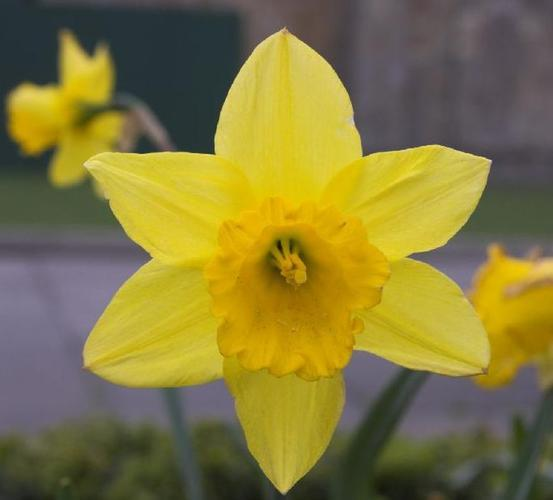

In [ ]:
import PIL
import PIL.Image

PIL.Image.open(dir_ + "/" + image_path["Image"][20])

## 2. Create a custom dataset from raw data

In [17]:
from pathlib import Path

image_dir_path = Path("jpg/")

if image_dir_path.is_dir():
    print(f"{image_dir_path} directory exists")
else:
    print(f"No image_path directory found")

jpg directory exists


### 2.1 Transform our data into tensors

In [84]:
data_transform = transforms.Compose([
    transforms.Resize(size=(256, 256)),
    transforms.RandomHorizontalFlip(p=0),
    transforms.ToTensor()
])

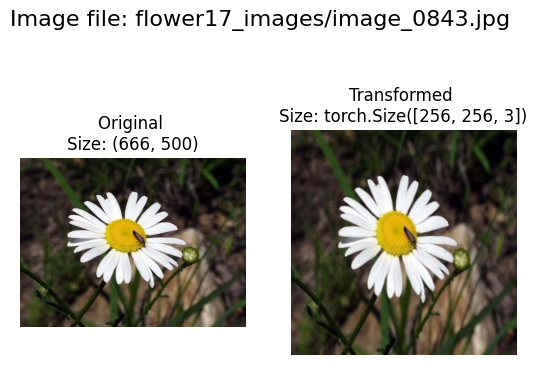

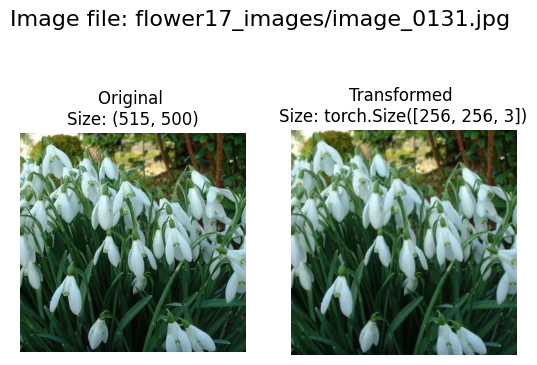

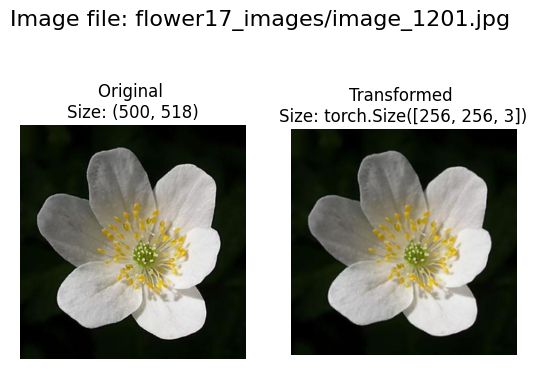

In [87]:
import os
import random

files = [f for f in os.listdir("flower17_images") if f.endswith(".jpg")]
random_sample = random.sample(files, k=3)

for filename in random_sample:
    image_path = os.path.join("flower17_images", filename)
    with PIL.Image.open(image_path) as f:
        fig, ax = plt.subplots(1, 2)

        ax[0].imshow(f)
        ax[0].set_title(f"Original \nSize: {f.size}")
        ax[0].axis("off")

        transformed_image = data_transform(f).permute(1, 2, 0)
        ax[1].imshow(transformed_image)
        ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
        ax[1].axis("off")

        fig.suptitle(f"Image file: {image_path}", fontsize=16)
        plt.show()

### 2.2 Rename images for easier labelling

Now, all our images in the `flower17_images` directory have different file names. We are going to rename all of them to match their corresponding labels. Remember how the first 80 images correspond to the first type of flower and the next 80 to the second type and so on. That is how we are going to rename our files for easier labelling and traversing while transforming them into tensors and giving each of them a label

In [88]:
image_label = 1
# dirname = Path("/train")
number_of_files_renamed = 0

files.sort()

for name in files:

    file_path = os.path.join("flower17_images", name)
    if number_of_files_renamed == 80:
        number_of_files_renamed = 0
        image_label += 1
    
    if image_label < 10:
        new_name = f"0{image_label}_{number_of_files_renamed}.jpg"
    else:
        new_name = f"{image_label}_{number_of_files_renamed}.jpg"
    
    new_path = os.path.join(image_dir_path, new_name)

    os.rename(file_path, new_path)
    number_of_files_renamed += 1

"""
The above code has already been executed and it has peformed it's function
"""

"\nThe above code has already been executed and it has peformed it's function\n"

In [ ]:
labels = [x for x in range(1, 18)]
labels

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

Now, we will seperate each image into a folder corresponding to its label

In [90]:
sorted(os.listdir(image_dir_path))

['.DS_Store',
 '01_0.jpg',
 '01_1.jpg',
 '01_10.jpg',
 '01_11.jpg',
 '01_12.jpg',
 '01_13.jpg',
 '01_14.jpg',
 '01_15.jpg',
 '01_16.jpg',
 '01_17.jpg',
 '01_18.jpg',
 '01_19.jpg',
 '01_2.jpg',
 '01_20.jpg',
 '01_21.jpg',
 '01_22.jpg',
 '01_23.jpg',
 '01_24.jpg',
 '01_25.jpg',
 '01_26.jpg',
 '01_27.jpg',
 '01_28.jpg',
 '01_29.jpg',
 '01_3.jpg',
 '01_30.jpg',
 '01_31.jpg',
 '01_32.jpg',
 '01_33.jpg',
 '01_34.jpg',
 '01_35.jpg',
 '01_36.jpg',
 '01_37.jpg',
 '01_38.jpg',
 '01_39.jpg',
 '01_4.jpg',
 '01_40.jpg',
 '01_41.jpg',
 '01_42.jpg',
 '01_43.jpg',
 '01_44.jpg',
 '01_45.jpg',
 '01_46.jpg',
 '01_47.jpg',
 '01_48.jpg',
 '01_49.jpg',
 '01_5.jpg',
 '01_50.jpg',
 '01_51.jpg',
 '01_52.jpg',
 '01_53.jpg',
 '01_54.jpg',
 '01_55.jpg',
 '01_56.jpg',
 '01_57.jpg',
 '01_58.jpg',
 '01_59.jpg',
 '01_6.jpg',
 '01_60.jpg',
 '01_61.jpg',
 '01_62.jpg',
 '01_63.jpg',
 '01_64.jpg',
 '01_65.jpg',
 '01_66.jpg',
 '01_67.jpg',
 '01_68.jpg',
 '01_69.jpg',
 '01_7.jpg',
 '01_70.jpg',
 '01_71.jpg',
 '01_72.jpg',


> We will now move each image into a folder which corresponds to its respective label. Since we will need to load this data into PyTorch and the images will be converted into tensors for efficient computation for vision tasks, it will be easier in terms of computing the label names and class indexes if they are segregated into different folders.

In [93]:
image_dir_path

PosixPath('jpg')

In [ ]:
train_folder_path = os.path.join(image_dir_path, "train")
train_folder_path2 = os.path.join(image_dir_path, "train2")

if os.path.isdir(train_folder_path2): # checking if the training folder exists or not
    for items in os.listdir(image_dir_path): # iterating through each file name in the directory
        file_path = os.path.join(image_dir_path, items)
        label_name = items[:2] # getting the label names of each image

        if not label_name.isdigit():
            continue

        if int(label_name) < 10:
            if os.path.isdir(os.path.join(train_folder_path2, label_name[1])): # checking if a folder with the name of the respective label exists
                new_path = os.path.join(train_folder_path2, label_name[1], items)
                os.rename(file_path, new_path) # renaming the file to be moved to the new path
            else: # a folder with the respective label does not exist
                dir_path = os.path.join(train_folder_path2, label_name[1]) # create a new dir with the label name
                os.mkdir(dir_path)
                new_path = os.path.join(dir_path, items)
                os.rename(file_path, new_path) # move file to new dir
        else:
            if os.path.isdir(os.path.join(train_folder_path2, label_name[:2])):
                new_path = os.path.join(train_folder_path2, label_name[:2], items)
                os.rename(file_path, new_path)
            else: 
                dir_path = os.path.join(train_folder_path2, label_name[:2])
                os.mkdir(dir_path)
                new_path = os.path.join(dir_path, items)
                os.rename(file_path, new_path)
else:
    os.mkdir(train_folder_path2)



We have now moved each image into the respective folder corresponding its label

Now, we need to see if we can derive our class names or labels based on the way we have structured our training directory

In [96]:
import os
train_folder_path = os.path.join(image_dir_path, "train")
train_folder_path2 = os.path.join(image_dir_path, "train2")

In [97]:
print(f"Target directory1: {train_folder_path2}")

class_names_found = sorted([int(entry.name) for entry in list(os.scandir(train_folder_path2))])
print(f"Class names found: {class_names_found}")

Target directory1: jpg/train2
Class names found: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]


### 2.3 Create a custom dataset like our image folder

In [98]:
from typing import Tuple, List, Dict

def find_class(target_dir: str) -> Tuple[List[int], Dict[int, int]]:
    """
    Finds the class folder names in a particular director
    assuming that the directory is in standard image classification format

    Args:
        target_dir: the target directory from where you will read the class names

    Returns:
        Tuple[List[int], Dict[int, int]]: (list_of_class_names, dict(class_name: index...))
    """
    classes = sorted(entry.name for entry in list(os.scandir(target_dir)) if entry.is_dir()) # gets the name of each folder inside the target_dir
    classes = list(map(int, classes)) # converting the class names from str to int
    classes.sort()

    if not classes:
        raise FileNotFoundError(f"Could not find any classes in {target_dir}")
    
    class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

    return classes, class_to_idx

find_class(train_folder_path2)

([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17],
 {1: 0,
  2: 1,
  3: 2,
  4: 3,
  5: 4,
  6: 5,
  7: 6,
  8: 7,
  9: 8,
  10: 9,
  11: 10,
  12: 11,
  13: 12,
  14: 13,
  15: 14,
  16: 15,
  17: 16})

This function above gives us the classes (labels) as well as a dictionary with the class names assigned with a particular index as well.

Now, we will convert our data folder into a custom ImageFolder dataset in order to load the images into PyTorch

In [4]:
from typing import Tuple, List, Dict
import torch

In [5]:
from torch.utils.data import Dataset
import pathlib
import PIL
import PIL.Image

class ImageFolderCustom(Dataset):
    def __init__(self, target_directory: str, transforms=None) -> None:

        # get all image paths
        self.paths = list(pathlib.Path(target_directory).glob("*/*.jpg")) # it iterates from the target_directory (jpg/train) into all the folders inside it and then gets the path of every image which has a .jpg extension
        self.transforms = transforms
        self.classes, self.class_to_idx = find_class(target_directory)

    def load_image(self, index: int) -> PIL.Image.Image:
        "Opens an image via a path and returns it"
        image_path = self.paths[index]
        return PIL.Image.open(image_path)
    
    def __len__(self) -> int:
        return len(self.paths)
    
    def get_random_samples(self) -> int:
        indexes = [x for x in range(0, len(self.paths))]
        return random.sample(indexes, k=80)
    
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        """
        Returns one single data, data & label (X, y)
        """

        image = self.load_image(index)
        class_name = int(self.paths[index].parent.name)
        class_idx = self.class_to_idx[class_name]

        if self.transforms:
            return self.transforms(image), class_idx
        else:
            return image, class_idx
        

In [26]:
train_folder_path

'jpg/train'

In [99]:
train_data = ImageFolderCustom(target_directory=train_folder_path2,
                               transforms=data_transform)
train_data

In [100]:
len(train_data)

1360

In [101]:
train_data.classes

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

In [102]:
train_data.class_to_idx

{1: 0,
 2: 1,
 3: 2,
 4: 3,
 5: 4,
 6: 5,
 7: 6,
 8: 7,
 9: 8,
 10: 9,
 11: 10,
 12: 11,
 13: 12,
 14: 13,
 15: 14,
 16: 15,
 17: 16}

### 2.4 Inspect the dataset

Now we have created our custom dataset. However, we need to inspect it to make sure that everything is correct and there have been no side-effects or error-prone results from our computations.

For this, let's create a function that displays random images from the dataset

In [103]:
import torch.utils.data.dataset


def random_samples(dataset: torch.utils.data.dataset.Dataset,
                   n=10,
                   classes: List[str] = None,
                   display_shape: bool = True,
                   seed: int = None):
    
    if n > 10:
        n = 10
        display_shape = False
        print(f"For efficiency, only 10 images can be displayed at once.")

    if seed:
        torch.manual_seed(seed=seed)

    random_samples_idx = random.sample(range(len(dataset)), k=n)
    plt.figure(figsize=(16, 8))

    for idx, target_sample in enumerate(random_samples_idx):
        print(f"target_sample: {target_sample}\nidx: {idx}")
        target_image, target_label = dataset[target_sample][0], dataset[target_sample][1]

        target_image = target_image.permute(1, 2, 0)

        plt.subplot(1, n, idx+1)
        plt.imshow(target_image)
        plt.axis(False)
        
        if classes:
            title = f"class: {classes[target_label]}"

        if display_shape:
            title = title + f" \nShape: {target_image.shape}"
        
        plt.title(title)

target_sample: 572
idx: 0
target_sample: 1237
idx: 1
target_sample: 1297
idx: 2
target_sample: 36
idx: 3
target_sample: 323
idx: 4


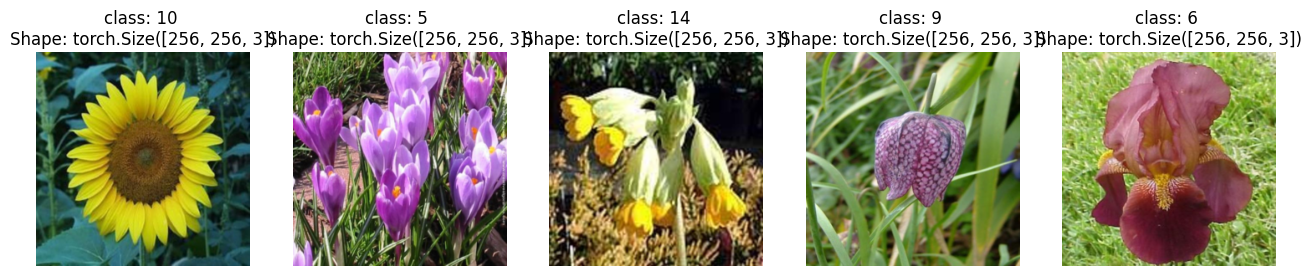

In [104]:
import random

random_samples(dataset=train_data,
               n=5,
               classes=class_names_found,
               seed=None)

In [105]:
image, label = train_data[0]
image, label

(tensor([[[0.6824, 0.6667, 0.6392,  ..., 0.6000, 0.5922, 0.5804],
          [0.6824, 0.6627, 0.6392,  ..., 0.5922, 0.5843, 0.5725],
          [0.6784, 0.6588, 0.6353,  ..., 0.5882, 0.5765, 0.5647],
          ...,
          [0.7608, 0.7529, 0.7451,  ..., 0.5098, 0.4706, 0.4431],
          [0.7412, 0.7373, 0.7333,  ..., 0.4902, 0.4471, 0.4196],
          [0.7373, 0.7373, 0.7333,  ..., 0.4824, 0.4353, 0.4078]],
 
         [[0.6275, 0.6235, 0.6118,  ..., 0.5569, 0.5647, 0.5569],
          [0.6275, 0.6235, 0.6078,  ..., 0.5569, 0.5608, 0.5529],
          [0.6314, 0.6235, 0.6039,  ..., 0.5569, 0.5569, 0.5451],
          ...,
          [0.6667, 0.6667, 0.6706,  ..., 0.4588, 0.4275, 0.4039],
          [0.6510, 0.6549, 0.6627,  ..., 0.4510, 0.4196, 0.3961],
          [0.6510, 0.6549, 0.6627,  ..., 0.4431, 0.4118, 0.3882]],
 
         [[0.5255, 0.5137, 0.4941,  ..., 0.4510, 0.4510, 0.4353],
          [0.5255, 0.5137, 0.4941,  ..., 0.4510, 0.4471, 0.4275],
          [0.5255, 0.5098, 0.4902,  ...,

In [106]:
class_names = train_data.classes
class_names

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

In [107]:
print(f"Shape of image: {image.shape}")
print(f"Label: {label}")

Shape of image: torch.Size([3, 256, 256])
Label: 8


Text(0.5, 1.0, '9: 8')

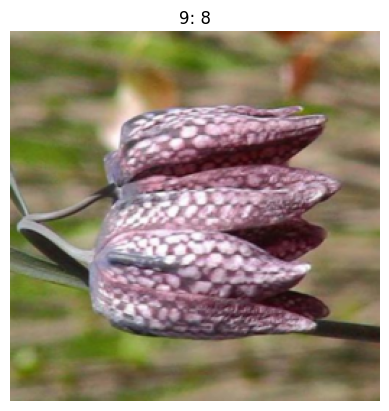

In [108]:
plt.imshow(image.T)
plt.axis(False)
plt.title(f"{class_names[label]}: {label}")

In [109]:
np.shape(image.squeeze()), np.shape(image.T)

(torch.Size([3, 256, 256]), torch.Size([256, 256, 3]))

Let us plot more images by creating subplots and inspecting the label and class names for a better perspective

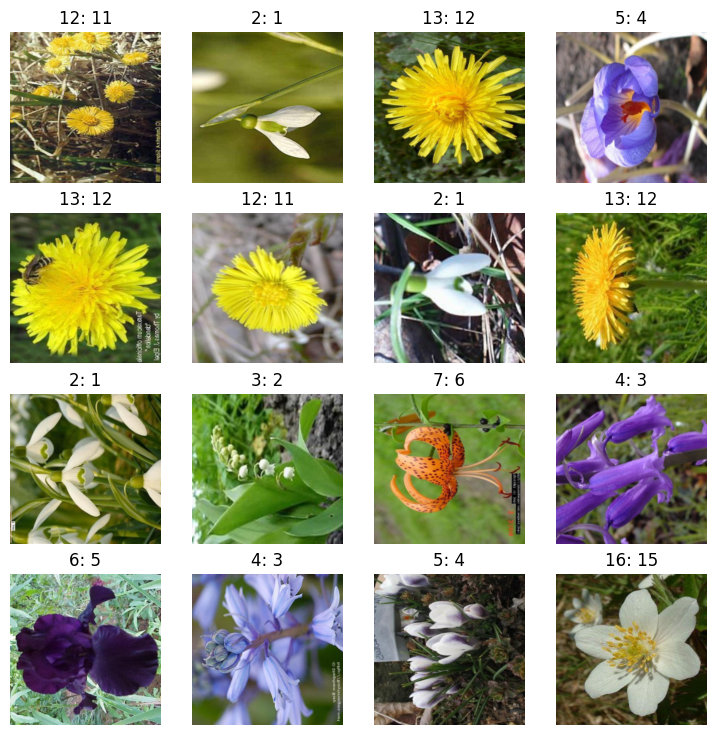

In [110]:
torch.manual_seed(42)

fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4

for i in range(1, rows*cols +1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()

    image, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)

    plt.imshow(image.T)
    plt.axis(False)
    plt.title(f"{class_names[label]}: {label}")

In [111]:
train_data

## 3. Prepare test dataset

Just like how created our training dataset, we also need to creating a test set for the model to test it's accuracy on and for us to see how accurate and efficient our model is. For this, we need to create a `test_data` subset from our `train_data` where it will not be of the same size, but smaller and more diverse in order to test our models effectively.

In [112]:
len(train_data)

1360

In [113]:
type(train_data)

__main__.ImageFolderCustom

In [114]:
train_data.get_random_samples()

[626,
 338,
 165,
 715,
 1089,
 502,
 178,
 711,
 666,
 126,
 10,
 1313,
 1218,
 288,
 1029,
 277,
 198,
 797,
 571,
 1186,
 1332,
 484,
 349,
 110,
 728,
 706,
 856,
 702,
 123,
 1315,
 230,
 1308,
 1288,
 185,
 61,
 441,
 1177,
 256,
 1164,
 875,
 1024,
 1001,
 290,
 1340,
 527,
 824,
 648,
 1189,
 115,
 782,
 1319,
 399,
 678,
 1309,
 932,
 134,
 716,
 972,
 644,
 260,
 1057,
 1103,
 324,
 132,
 287,
 686,
 333,
 131,
 634,
 481,
 656,
 174,
 340,
 1268,
 442,
 928,
 460,
 532,
 46,
 506]

In [115]:
len(train_data.get_random_samples())

80

Now, since we can get 80 random index values from our `train_data` which happens to be the `Tuple(image, label)`, we can use the 80 random samples to generate a test dataset for evaluating the model.

In [6]:
# We will use this class to create a custom test dataset from the output we get from the get_random_samples() from train_data

class CustomTestDataset(Dataset):
    def __init__(self, data, label):
        self.data = data
        self.label = label

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index], self.label[index]

In [117]:
images, labels = [], []

for item in train_data.get_random_samples():
    images.append(train_data[item][0])
    labels.append(train_data[item][1])

len(images), len(labels)

(80, 80)

In [118]:
images

[tensor([[[0.2588, 0.2745, 0.2627,  ..., 0.1333, 0.1373, 0.1412],
          [0.2431, 0.2745, 0.2745,  ..., 0.1373, 0.1373, 0.1412],
          [0.2549, 0.2902, 0.2980,  ..., 0.1412, 0.1373, 0.1412],
          ...,
          [0.3176, 0.2824, 0.2431,  ..., 0.1882, 0.1922, 0.1882],
          [0.3098, 0.2784, 0.2510,  ..., 0.2078, 0.2157, 0.2157],
          [0.3137, 0.2902, 0.2627,  ..., 0.2157, 0.2157, 0.2118]],
 
         [[0.1843, 0.2000, 0.1882,  ..., 0.1137, 0.1176, 0.1176],
          [0.1686, 0.2000, 0.2000,  ..., 0.1176, 0.1137, 0.1137],
          [0.1804, 0.2196, 0.2275,  ..., 0.1216, 0.1098, 0.1098],
          ...,
          [0.2667, 0.2275, 0.1882,  ..., 0.1608, 0.1765, 0.1804],
          [0.2549, 0.2235, 0.1922,  ..., 0.1765, 0.1961, 0.2078],
          [0.2627, 0.2353, 0.2078,  ..., 0.1843, 0.1961, 0.2039]],
 
         [[0.1804, 0.1725, 0.1255,  ..., 0.1373, 0.1373, 0.1255],
          [0.1647, 0.1725, 0.1412,  ..., 0.1412, 0.1333, 0.1216],
          [0.1882, 0.2039, 0.1804,  ...,

In [119]:
labels

[1,
 11,
 11,
 7,
 6,
 15,
 6,
 3,
 4,
 7,
 1,
 15,
 8,
 8,
 0,
 8,
 13,
 3,
 14,
 4,
 7,
 5,
 10,
 13,
 11,
 13,
 1,
 15,
 15,
 2,
 5,
 8,
 4,
 9,
 14,
 3,
 6,
 13,
 3,
 12,
 7,
 11,
 10,
 9,
 9,
 7,
 1,
 5,
 2,
 14,
 14,
 5,
 2,
 9,
 6,
 12,
 2,
 14,
 4,
 5,
 16,
 3,
 8,
 14,
 3,
 16,
 4,
 16,
 9,
 4,
 15,
 9,
 10,
 13,
 3,
 2,
 5,
 10,
 6,
 8]

In [120]:
test_dataset = CustomTestDataset(images, labels)
test_dataset

In [121]:
test_dataset[0]

(tensor([[[0.2588, 0.2745, 0.2627,  ..., 0.1333, 0.1373, 0.1412],
          [0.2431, 0.2745, 0.2745,  ..., 0.1373, 0.1373, 0.1412],
          [0.2549, 0.2902, 0.2980,  ..., 0.1412, 0.1373, 0.1412],
          ...,
          [0.3176, 0.2824, 0.2431,  ..., 0.1882, 0.1922, 0.1882],
          [0.3098, 0.2784, 0.2510,  ..., 0.2078, 0.2157, 0.2157],
          [0.3137, 0.2902, 0.2627,  ..., 0.2157, 0.2157, 0.2118]],
 
         [[0.1843, 0.2000, 0.1882,  ..., 0.1137, 0.1176, 0.1176],
          [0.1686, 0.2000, 0.2000,  ..., 0.1176, 0.1137, 0.1137],
          [0.1804, 0.2196, 0.2275,  ..., 0.1216, 0.1098, 0.1098],
          ...,
          [0.2667, 0.2275, 0.1882,  ..., 0.1608, 0.1765, 0.1804],
          [0.2549, 0.2235, 0.1922,  ..., 0.1765, 0.1961, 0.2078],
          [0.2627, 0.2353, 0.2078,  ..., 0.1843, 0.1961, 0.2039]],
 
         [[0.1804, 0.1725, 0.1255,  ..., 0.1373, 0.1373, 0.1255],
          [0.1647, 0.1725, 0.1412,  ..., 0.1412, 0.1333, 0.1216],
          [0.1882, 0.2039, 0.1804,  ...,

## 4. Create and prepare DataLoader

Now, we are going to feed these into the PyTorch `DataLoader` class and turn them into dataloaders that will create an iterable over the dataset. This will make it easier for us when we have to seperate them into batches for training and later for testing as well.

In [122]:
from torch.utils.data import DataLoader

# BATCH_SIZE represents how many chunks we want to split our data into for efficient computation during training
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                               batch_size=BATCH_SIZE,
                               shuffle=True)

train_dataloader

In [123]:
test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

test_dataloader

In [124]:
print(f"Length of train_dataloader: {len(train_dataloader)} of {BATCH_SIZE} batches")
print(f"Length of test_dataloader: {len(test_dataloader)} of {BATCH_SIZE} batches")

Length of train_dataloader: 43 of 32 batches
Length of test_dataloader: 3 of 32 batches


In [125]:
1360 / 32, 1360 // 32

(42.5, 42)

In [126]:
80 / 32, 80 // 32

(2.5, 2)

### 4.1 Inspect the dataloaders

In [127]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

In [128]:
test_features_batch, test_labels_batch = next(iter(test_dataloader))
test_features_batch.shape, test_labels_batch.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

#### 4.1.1 Plot a random image from train and test batches

Text(0.5, 1.0, '4: 3')

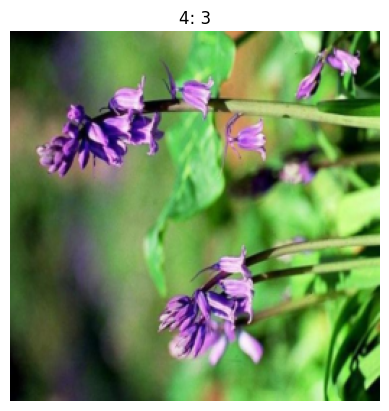

In [129]:
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
random_img, random_lb = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(random_img.T)
plt.axis(False)
plt.title(f"{class_names[random_lb]}: {random_lb}")

Text(0.5, 1.0, '16: 15')

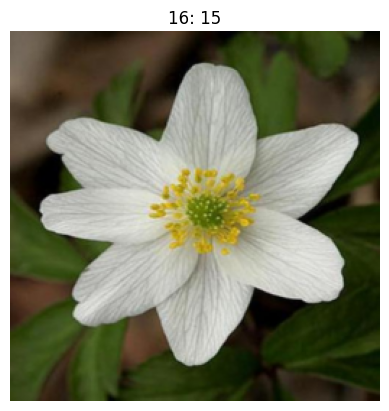

In [130]:
random_idx = torch.randint(0, len(test_features_batch), size=[1]).item()
rand_img, rand_lb = test_features_batch[random_idx], test_labels_batch[random_idx]
plt.imshow(rand_img.T)
plt.axis(False)
plt.title(f"{class_names[rand_lb]}: {rand_lb}")

## 5. Build a CNN

We will now build a Convolutional Neural Network, also known as a ConvNet. We are going to base the architecture of the model on the TinyVGG model architecture. You can learn more about it [here](https://cs231n.stanford.edu/).

In [139]:
class Flower17v1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape):
        super().__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*4096,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.classifier(x)
        return x

In [132]:
device

'mps'

In [133]:
image.shape

torch.Size([3, 256, 256])

In [134]:
len(class_names), class_names

(17, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])

In [147]:
model_0 = Flower17v1(input_shape=3,
                     hidden_units=64,
                     output_shape=len(class_names))
model_0.to(device=device)

model_0

Flower17v1(
  (conv_block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=262144, out_features=17, bias=True)
  )
)

In [148]:
random_image_tensor = torch.randn(size=image.shape)

model_0(random_image_tensor.unsqueeze(0).to(device=device))

tensor([[ 1.0124e-02, -1.1117e-02, -2.2955e-03,  2.2587e-02,  2.6314e-02,
          1.9210e-03, -8.2373e-06,  1.3367e-02, -1.3246e-03,  1.3595e-02,
         -5.0938e-02,  4.4002e-03,  6.7884e-02,  1.5431e-03,  2.4863e-02,
          2.4449e-02,  2.8841e-03]], device='mps:0', grad_fn=<LinearBackward0>)

In [138]:
10 * 4096

40960

### 5.1 Set up loss function and optimizer for model_0

In [149]:
loss_0 = nn.CrossEntropyLoss()
optimizer_0 = torch.optim.SGD(params=model_0.parameters(),
                               lr=0.01)

loss_0, optimizer_0

(CrossEntropyLoss(),
 SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     momentum: 0
     nesterov: False
     weight_decay: 0
 ))

## 6. Training and testing model_0

### 6.1 Create training and testing functions

A lot of time can be saved and code redundancy avoided if we can code a train and test function for our models to use. Since the process will always be the same, we can create train and test functions which follow the same steps.

First, we will create a training function `model_train()` that takes in the model, the train dataloader, device (for device-agnostic code), loss function, optimizer. We will also pass in an accuracy function that we will create below. So the function will look something like:

```
model_train(model: nn.Module, dataloader: torch.utils.data.DataLoader, device: torch.device, loss_fn: nn.Module, optimizer_fn: torch.optim, accuracy_fn)
```

In [25]:
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_pred, y_true).sum().item()
    accuracy = (correct / len(y_pred)) * 100
    return accuracy

In [68]:
d = torch.device(device)
type(d)

torch.device

In [133]:
def model_train(model: nn.Module,
                dataloader: torch.utils.data.DataLoader,
                device: torch.device,
                loss_fn: nn.Module,
                optimizer_fn: torch.optim,
                lr_scheduler: bool = False,
                accuracy_fn=accuracy_fn):
    model.to(device=device)
    model.train()

    train_loss, train_acc = 0, 0 # these variables will accumulate the loss and accuracy scores for each iteration

    # iterate over the batch, (image, label) in the dataloader
    for batch, (X_feature, y_label) in enumerate(dataloader):
        # send the features and labels to the target device
        X_feature, y_label = X_feature.to(device), y_label.to(device)

        y_predictions = model(X_feature) # send the features to the forward pass

        # calculate loss and accuracy and add them to the train_loss and train_acc
        loss = loss_fn(y_predictions, y_label)
        acc = accuracy_fn(y_predictions.argmax(dim=1), 
                          y_label)
        train_loss += loss
        train_acc += acc

        optimizer_fn.zero_grad() # set the gradients to zero
        loss.backward() # perform backpropagation
        optimizer_fn.step() # step the optimizer

        if not lr_scheduler:
            continue
        else:
            torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer_fn).step(metrics=loss)
            

    # divide both the variables with accumulated values by total length to get the final result value
    train_loss /= len(dataloader) 
    train_acc /= len(dataloader)

    print(f"Training loss: {train_loss: .4f} | Training acc: {train_acc: .2f}%")

Now, we will create a function to replicate the testing loop for evaluation our model. The function `model_test()` will take the model, dataloader with the training samples, the loss function, accuracy function as well as the device. It will be as follows:

```
model_test(model: nn.Module, dataloader: torch.utils.data.DataLoader, loss_fn: nn.Module,  accuracy_fn, device: torch.device)
```

In [27]:
def model_test(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               device: torch.device,
               accuracy_fn=accuracy_fn,):
    
    test_loss, test_acc = 0, 0 # these variables will accumulate the loss and accuracy for each iteration over the iterables in the dataloader

    model.to(device=device) # put the model on target device
    model.eval() # set the model to eval mode for testing

    with torch.inference_mode():
        for X_features, y_label in dataloader:
            X_features, y_label = X_features.to(device), y_label.to(device)

            test_prediction = model(X_features)

            loss = loss_fn(test_prediction, y_label)
            acc = accuracy_fn(y_pred=test_prediction.argmax(dim=1), 
                              y_true=y_label)

            test_loss += loss
            test_acc += acc

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)

        print(f"Test loss: {test_loss: .4f} | Test acc: {test_acc: .2f}%")

In [71]:
next(model_0.parameters()).device

device(type='mps', index=0)

Let us also create a function that will return the total time taken for the model to perform the training loop as a dictionary

In [28]:
def print_train_time(model: nn.Module,
                     start_time: float,
                     end_time: float, 
                     device: torch.device):
    time_taken = end_time - start_time
    train_time = dict({
        "model": model._get_name(),
        "device": device,
        "train_time": time_taken
    })
    return train_time

### 6.2 Perform training and testing for model_0

Now, we will perform the training and testing loop for our **`model_0`, the first baseline model**. In order to calculate the efficiency our model, we will train it on the gpu and measure the time taken to perform training as well as compare the loss and accuracy metrics.

#### 6.2.1 Train model_0 on gpu

In [73]:
import time
from tqdm.auto import tqdm

In [74]:
device

'mps'

In [150]:
epochs = 10 # start with 10 epochs
start_train_time_on_gpu_model_0 = time.time()

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}---\n")
    
    model_train(model=model_0,
                dataloader=train_dataloader,
                device=device,
                loss_fn=loss_0,
                optimizer_fn=optimizer_0,
                accuracy_fn=accuracy_fn)
    
    model_test(model=model_0,
               dataloader=test_dataloader,
               loss_fn=loss_0,
               device=device,
               accuracy_fn=accuracy_fn)
    
stop_train_time_on_gpu_model_0 = time.time()
model_0_train_time = print_train_time(model=model_0, start_time=start_train_time_on_gpu_model_0, end_time=stop_train_time_on_gpu_model_0, device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0---

Training loss:  2.8160 | Training acc:  8.79%
Test loss:  2.7134 | Test acc:  25.00%
Epoch: 1---

Training loss:  2.4547 | Training acc:  19.77%
Test loss:  2.3155 | Test acc:  18.75%
Epoch: 2---

Training loss:  2.0009 | Training acc:  32.34%
Test loss:  1.9549 | Test acc:  37.50%
Epoch: 3---

Training loss:  1.7797 | Training acc:  40.26%
Test loss:  1.7843 | Test acc:  38.54%
Epoch: 4---

Training loss:  1.6103 | Training acc:  47.24%
Test loss:  1.3657 | Test acc:  52.08%
Epoch: 5---

Training loss:  1.4807 | Training acc:  51.45%
Test loss:  2.0109 | Test acc:  35.42%
Epoch: 6---

Training loss:  1.3801 | Training acc:  58.58%
Test loss:  1.1826 | Test acc:  60.42%
Epoch: 7---

Training loss:  1.2370 | Training acc:  60.90%
Test loss:  1.5812 | Test acc:  62.50%
Epoch: 8---

Training loss:  1.2371 | Training acc:  64.03%
Test loss:  1.2070 | Test acc:  62.50%
Epoch: 9---

Training loss:  0.9274 | Training acc:  70.49%
Test loss:  1.4283 | Test acc:  56.25%


In [158]:
model_0_train_time

{'model': 'Flower17v1', 'device': 'mps', 'train_time': 451.3969089984894}

Our model has achieved a 70% training accuracy. However, the test accuracy is extremely low for it to be considered an effective model.

Let us create a function that evaluates the accuracy of a model. The function will be same as the test function, only difference being it returns a dictionary with the metrics so that we can compare our model to other models.

### 6.3 Evaluate baseline model

In [29]:
import torch.utils.data.dataloader


def eval_model(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               device: torch.device,
               accuracy_fn=accuracy_fn):
    
    model.to(device=device) # put model on the target device
    
    loss, acc = 0, 0 # to accumulate the losses and accuracies

    model.eval() # set model to eval mode
    with torch.inference_mode():
        for X_feature, y_label in dataloader:
            X_feature, y_label = X_feature.to(device), y_label.to(device)

            pred = model(X_feature)

            loss += loss_fn(pred, y_label)
            acc += accuracy_fn(y_pred=pred.argmax(dim=1),
                               y_true=y_label)
            
        loss /= len(dataloader)
        acc /= len(dataloader)
    
    return {
        "model": model.__class__.__name__,
        "loss": float(f"{loss: .4f}"),
        "accuracy": acc
    }

    

In [155]:
model_0_eval = eval_model(model=model_0,
                          dataloader=test_dataloader,
                          loss_fn=loss_0,
                          device=device,
                          accuracy_fn=accuracy_fn)

model_0_eval

{'model': 'Flower17v1', 'loss': 1.4283, 'accuracy': 56.25}

As we can see, the result of the evaluations is the same as the testing accuracy we got in the training step.

In [279]:
def save_model(model: nn.Module, save_name: str):
    MODEL_PATH = Path("models")
    MODEL_PATH.mkdir(parents=True, exist_ok=True)

    MODEL_SAVE_PATH = MODEL_PATH / save_name

    print(f"Saving model to {MODEL_SAVE_PATH}")
    torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

In [280]:
save_model(model=model_0, save_name="flower17_model_0.pt")

Saving model to models/flower17_model_0.pt


## 7. Build a larger CNN

We have seen how our baseline model with just 2 convolutional blocks did ramp up its performance but did not achieve a good test score. Now, we will try to build a larger and deeper network which will give the model a chance to learn more features and perform better.

In [7]:
import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader

In [8]:
train_dataloader = torch.load("train_dataloader.pt", weights_only=False)
test_dataloader = torch.load("test_dataloader.pt", weights_only=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x11de9c050>,
 <torch.utils.data.dataloader.DataLoader at 0x11de2efd0>)

In [9]:
len(train_dataloader), len(test_dataloader)

(43, 3)

Here are the things that will be different from our previous model:

* Increased number of channels - We will successively increase the number of channels as we go deeper
* Using a different optimizer
* Using a learning rate scheduler

In [13]:
device

'mps'

In [14]:
torch.save(train_dataloader, "train_dataloader.pt")
torch.save(test_dataloader, "test_dataloader.pt")

In [135]:
class Flower17v2(nn.Module):
    def __init__(self, input_shape: int, output_shape: int):
        super().__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=64,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=128,
                      out_channels=128,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(in_channels=256,
                      out_channels=256,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256,
                      out_channels=512,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.adaptive_pooling = nn.AdaptiveAvgPool2d((4,4))

        self.layer_final = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=512*16,
                      out_features=len(class_names))
        )

    def forward(self, x: torch.tensor) -> torch.tensor:
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)

        x = self.adaptive_pooling(x)

        x = self.layer_final(x)
        return x


We have  now built a model that is 17 layers deep, with filters progressing from `3 -> 64 -> 128 -> 256 -> 256 -> 128 -> 64 -> 17`. This looks sophisticated enough so let us move on!

In [88]:
class_names  = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]

In [136]:
model_1 = Flower17v2(input_shape=3,
                     output_shape=len(class_names))

model_1

Flower17v2(
  (conv_block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential

In [41]:
rand_img1 = torch.randn([3, 256, 256])
rand_img1.shape

torch.Size([3, 256, 256])

In [42]:
model_1(rand_img1)

/Users/adrinorosario/Desktop/flowers102/lib/python3.13/site-packages/torch/nn/functional.py:1545: UserWarning: dropout2d: Received a 3D input to dropout2d and assuming that channel-wise 1D dropout behavior is desired - input is interpreted as shape (N, C, L), where C is the channel dim. This behavior will change in a future release to interpret the input as one without a batch dimension, i.e. shape (C, H, W). To maintain the 1D channel-wise dropout behavior, please switch to using dropout1d instead.
  warnings.warn(


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x16 and 1024x17)

In [58]:
64 * 64

4096

### 7.1 Loss function, Optimizer and Learning Rate Scheduler

Now, coming to the optimizer. For this model, we will use the Adam optimizer for faster convergence. Here, we will also use a learning rate scheduler to help us tune or adjust the learning rate after each epoch for faster and better convergence.

In [137]:
loss_1 = nn.CrossEntropyLoss()
optimizer_1 = torch.optim.Adam(params=model_1.parameters(),
                               lr=0.01)
optimizer_1_1 = torch.optim.SGD(params=model_1.parameters(),
                                lr=0.1,
                                momentum=0.9,
                                weight_decay=0.0001)

# we will experiment with two different learning rate schedulers: StepLR and ExponentialLR

scheduler_1_0 = torch.optim.lr_scheduler.StepLR(optimizer=optimizer_1,
                                                step_size=2,
                                                gamma=0.2)

scheduler_1_1 = torch.optim.lr_scheduler.ExponentialLR(optimizer=optimizer_1,
                                                       gamma=0.2)

Since we now have a learning rate scheduler, we need to ensure that we place it correctly in our training loop.

### 7.2 Train model_1

We will experiment with the schedulers by:
* Using only StepLR as our LR scheduler
* Using only ExponentialLR as our LR scheduler
* Chaining both the schedulers

We will compare the results from all 3 instances and choose the best option.

In [138]:
import time
from tqdm.auto import tqdm

epochs = 10

start_train_time_on_gpu_model_1 = time.time()

for epoch in tqdm(range(epochs)):
    print(f"\nEpoch: {epoch}---")

    model_train(model=model_1,
                dataloader=train_dataloader,
                device=device,
                loss_fn=loss_1,
                optimizer_fn=optimizer_1_1,
                lr_scheduler=True,
                accuracy_fn=accuracy_fn)
    
    # scheduler_1_0.step()
    # scheduler_1_1.step()
    
    model_test(model=model_1,
               dataloader=test_dataloader,
               loss_fn=loss_1,
               device=device,
               accuracy_fn=accuracy_fn)
    
    # torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer_1_1,).step()

stop_train_time_on_gpu_model_1 = time.time()

model_1_train_time = print_train_time(model=model_1,
                                      start_time=start_train_time_on_gpu_model_1,
                                      end_time=stop_train_time_on_gpu_model_1,
                                      device=device)
 
model_1_train_time

  0%|          | 0/10 [00:00<?, ?it/s]


Epoch: 0---
Training loss:  10.7490 | Training acc:  10.68%
Test loss:  2.9660 | Test acc:  14.58%

Epoch: 1---
Training loss:  2.5864 | Training acc:  14.32%
Test loss:  2.5068 | Test acc:  16.67%

Epoch: 2---
Training loss:  2.4865 | Training acc:  17.44%
Test loss:  2.3760 | Test acc:  23.96%

Epoch: 3---
Training loss:  2.4367 | Training acc:  17.37%
Test loss:  2.4083 | Test acc:  26.04%

Epoch: 4---
Training loss:  2.4365 | Training acc:  17.59%
Test loss:  2.3548 | Test acc:  20.83%

Epoch: 5---
Training loss:  2.3508 | Training acc:  19.11%
Test loss:  2.2243 | Test acc:  22.92%

Epoch: 6---
Training loss:  2.3542 | Training acc:  18.82%
Test loss:  2.1464 | Test acc:  30.21%

Epoch: 7---
Training loss:  2.2578 | Training acc:  23.55%
Test loss:  2.1161 | Test acc:  31.25%

Epoch: 8---


RuntimeError: MPS backend out of memory (MPS allocated: 15.60 GB, other allocations: 1.72 GB, max allowed: 18.13 GB). Tried to allocate 1024.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

We ran out of memory but as we can see, the new model was performing better and with sufficient epochs, might be able to outperform the baseline model.

Let us try and evaluate our model now with how much ever it has trained.

In [139]:
model_1_eval =  eval_model(model=model_1,
                    dataloader=test_dataloader,
                    loss_fn=loss_1,
                    device=device,
                    accuracy_fn=accuracy_fn)

In [140]:
model_1_eval

{'model': 'Flower17v2', 'loss': 2.1034, 'accuracy': 33.333333333333336}

As we can see, our model has performed according to the latest accuracy score from the test run of our training loop.

Now we can begin to start working on the larger 102 class dataset.